# Loan repayment

In [201]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

random_seed = 42

import warnings
warnings.filterwarnings('ignore')
from scipy import stats
import os, sys, json

from sklearn.preprocessing import  StandardScaler , OneHotEncoder # LabelEncoder, RobustScaler, MinMaxScaler,

# from sklearn.tree import DecisionTreeClassifier
# from sklearn.linear_model import LogisticRegression, LinearRegression,  SGDRegressor, Ridge, RidgeCV
# from sklearn.ensemble import GradientBoostingClassifier, RandomForestClassifier, GradientBoostingRegressor, StackingClassifier
 
# from imblearn.over_sampling import SMOTE
# from sklearn.model_selection import train_test_split #cross_val_score, RandomizedSearchCV, GridSearchCV, StratifiedKFold, LeaveOneOut, cross_validate

# from sklearn.ensemble import RandomForestRegressor, StackingRegressor
# from sklearn.metrics import classification_report, mean_squared_error, mean_absolute_error, mean_absolute_percentage_error, roc_curve, roc_auc_score, f1_score, median_absolute_error #auc,
# #from sklearn import metrics

# from sklearn.feature_selection import SelectKBest, f_regression

from sklearn.pipeline import Pipeline
from sklearn.ensemble import RandomForestRegressor

from sklearn.model_selection import train_test_split
from sklearn.compose import make_column_transformer
from imblearn.over_sampling import SMOTE
from sklearn.impute import KNNImputer

import optuna
import pickle


# Hides output while after model learned
from IPython.display import clear_output

# Display fixed length of a dataframe
pd.set_option("display.max_rows", 9, "display.max_columns", 9)

#set path
sys.path.insert(1, '../')

!pip freeze > requirements.txt

In [202]:
from utils.config_reader import config_reader
from utils.functions import get_descr

# Import parameters
config = config_reader('../config/config.json')

random_seed = config.random_seed
path_figures = config.path_figures

os.environ['PYTHONHASHSEED'] = str(random_seed)
np.random.seed(random_seed)
from optuna.samplers import TPESampler
sampler = TPESampler(seed=random_seed) # fix random seed

## Read files

In [203]:
# df = pd.read_csv('../data/accepted_2007_to_2018Q4.csv.gz')
# df

# sample = df.sample(n=100000 , axis=0, random_state=random_seed)
# display(sample)
# sample.to_csv('../data/sample.csv') 

In [204]:
data = pd.read_csv('../data/sample.zip')
data.drop(['Unnamed: 0', 'id'], axis=1, inplace=True)
data.tail()

,member_id,loan_amnt,funded_amnt,funded_amnt_inv,...,settlement_date,settlement_amount,settlement_percentage,settlement_term
99995,NaN,22000.0,22000.0,22000.0,...,NaN,NaN,NaN,NaN
99996,NaN,25200.0,25200.0,25200.0,...,NaN,NaN,NaN,NaN
99997,NaN,10000.0,10000.0,10000.0,...,NaN,NaN,NaN,NaN
99998,NaN,20000.0,20000.0,20000.0,...,NaN,NaN,NaN,NaN
99999,NaN,12000.0,12000.0,12000.0,...,NaN,NaN,NaN,NaN


Read feature description.

# 0. Dataset preparation

In order to do feature analysis it is better to start from object columns

In [205]:
data.columns.to_list()

['member_id',
 'loan_amnt',
 'funded_amnt',
 'funded_amnt_inv',
 'term',
 'int_rate',
 'installment',
 'grade',
 'sub_grade',
 'emp_title',
 'emp_length',
 'home_ownership',
 'annual_inc',
 'verification_status',
 'issue_d',
 'loan_status',
 'pymnt_plan',
 'url',
 'desc',
 'purpose',
 'title',
 'zip_code',
 'addr_state',
 'dti',
 'delinq_2yrs',
 'earliest_cr_line',
 'fico_range_low',
 'fico_range_high',
 'inq_last_6mths',
 'mths_since_last_delinq',
 'mths_since_last_record',
 'open_acc',
 'pub_rec',
 'revol_bal',
 'revol_util',
 'total_acc',
 'initial_list_status',
 'out_prncp',
 'out_prncp_inv',
 'total_pymnt',
 'total_pymnt_inv',
 'total_rec_prncp',
 'total_rec_int',
 'total_rec_late_fee',
 'recoveries',
 'collection_recovery_fee',
 'last_pymnt_d',
 'last_pymnt_amnt',
 'next_pymnt_d',
 'last_credit_pull_d',
 'last_fico_range_high',
 'last_fico_range_low',
 'collections_12_mths_ex_med',
 'mths_since_last_major_derog',
 'policy_code',
 'application_type',
 'annual_inc_joint',
 'dti_joi

In [206]:
num_features, cat_features = [s for s in data.columns if data[s].dtypes != 'object'], [s for s in data.columns if data[s].dtypes == 'object']
#cat_features

In order to do feature analysis we should select features which might affect the target.

In [207]:
selected_cols = [
    'loan_amnt', 'term', 'int_rate', 'installment', 'grade', 'sub_grade', 'emp_title', 'emp_length', \
    'home_ownership', 'annual_inc', 'verification_status', 'issue_d', 'loan_status','pymnt_plan',\
    'purpose','title','zip_code','dti','earliest_cr_line','open_acc','pub_rec','revol_bal',\
    'revol_util','total_acc','initial_list_status','application_type','mort_acc','pub_rec_bankruptcies',\
    'hardship_flag','hardship_length','total_bal_il','settlement_percentage']

data = data[selected_cols]
data.head()

,loan_amnt,term,int_rate,installment,...,hardship_flag,hardship_length,total_bal_il,settlement_percentage
0,32000.0,60 months,10.49,687.65,...,N,NaN,NaN,NaN
1,9600.0,36 months,12.99,323.42,...,N,NaN,NaN,NaN
2,4000.0,36 months,6.68,122.93,...,N,NaN,NaN,NaN
3,6025.0,36 months,10.91,197.00,...,N,NaN,2853.0,NaN
4,25000.0,60 months,26.30,752.96,...,N,NaN,48186.0,NaN


# 1. EDA

### Loan_status (target feature)

There are several loan repayment outcomes which can be used as targets.

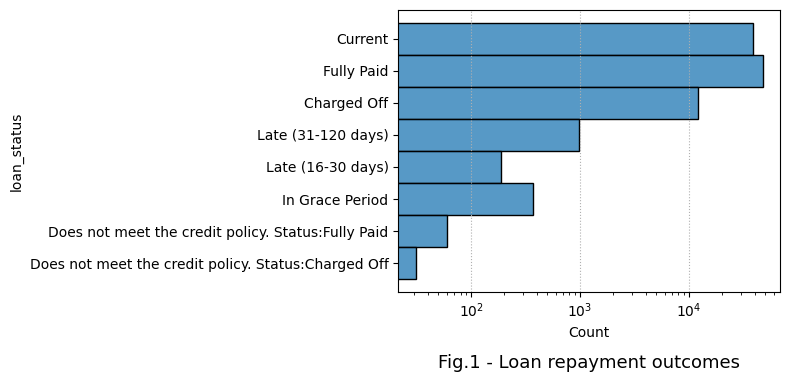

In [208]:
fig, ax = plt.subplots(figsize=(8, 4))
fig = sns.histplot(data, y='loan_status')
fig.set_title('Fig.1 - Loan repayment outcomes', y=-0.3, fontsize=13)
ax.set_xscale('log')
fig_id=1
plt.tight_layout()
ax.xaxis.grid(linestyle=':')
plt.savefig(os.path.join(path_figures, f'fig_{fig_id}.png'));

To simplify the task let us exclude customers who either do not meet the credit policy or who are in the grace period.

In [209]:
data['loan_status'].value_counts(True)

Fully Paid                                             0.474619
Current                                                0.388886
Charged Off                                            0.120345
Late (31-120 days)                                     0.009690
In Grace Period                                        0.003680
Late (16-30 days)                                      0.001870
Does not meet the credit policy. Status:Fully Paid     0.000600
Does not meet the credit policy. Status:Charged Off    0.000310
Name: loan_status, dtype: float64

In [210]:
data = data.query("loan_status in ['Fully Paid', 'Charged Off', 'Late (31-120 days)', 'Late (16-30 days)']") #'Current',
data.iloc[:,:8].columns

Index(['loan_amnt', 'term', 'int_rate', 'installment', 'grade', 'sub_grade',
       'emp_title', 'emp_length'],
      dtype='object')

In [211]:
data = data[['loan_amnt', 'term', 'int_rate', 'installment', 'grade', 'sub_grade',
       'emp_title', 'emp_length','loan_status']]

### grade and sub_grade

In [212]:
get_descr('grade')

LC assigned loan grade


In [213]:
get_descr('sub_grade')

LC assigned loan subgrade


In [214]:
data['grade'].value_counts(True)

B    0.288326
C    0.286150
A    0.169398
D    0.153124
E    0.071525
F    0.024287
G    0.007189
Name: grade, dtype: float64

In [215]:
data[['grade','sub_grade']]

,grade,sub_grade
1,C,C1
2,A,A3
3,B,B4
5,B,B2
...,...,...
99994,B,B3
99996,D,D3
99997,C,C2
99999,A,A2


In [216]:
data['grade'].compare(data['sub_grade'].astype(str).str[0])

,self,other


Number of unique categories:  35


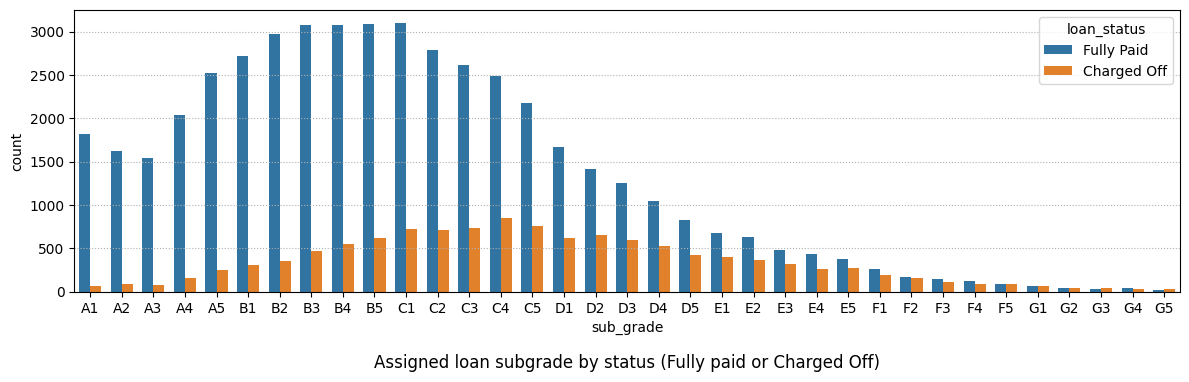

In [217]:
new_order = list(np.sort(data['sub_grade'].unique()))
print('Number of unique categories: ', len(new_order))
temp = data[(data['loan_status']=='Fully Paid') | (data['loan_status']=='Charged Off')]
fig_id=2

fig, ax = plt.subplots(figsize=(12, 4))
ax = sns.countplot(data=temp, x='sub_grade', hue='loan_status', width=0.7, order=new_order)
ax.yaxis.grid(linestyle=':')
ax.set_title(f'Assigned loan subgrade by status (Fully paid or Charged Off)', y=-0.3);
#ax.set_yscale('log');
plt.tight_layout()

Number of unique categories:  7


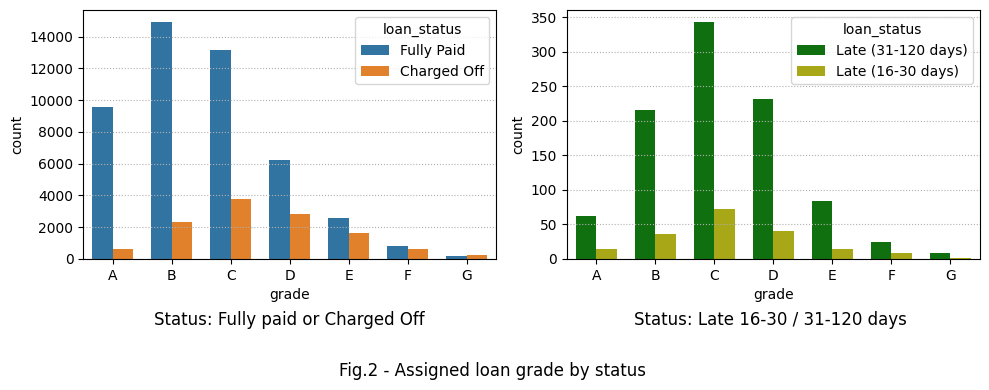

In [218]:
new_order = list(np.sort(data['grade'].unique()))
print('Number of unique categories: ', len(new_order))
temp1 = data[(data['loan_status']=='Fully Paid') | (data['loan_status']=='Charged Off')]
temp2 = data[(data['loan_status']=='Late (16-30 days)') | (data['loan_status']=='Late (31-120 days)')]
fig_id=2

fig, ax = plt.subplots(1,2, figsize=(10, 4))
sns.countplot(data=temp1, x='grade', hue='loan_status', width=0.7, ax=ax[0], order=new_order) #, palette=['b','r']
ax[0].yaxis.grid(linestyle=':')
ax[0].set_title('Status: Fully paid or Charged Off', y=-0.3)

ax[1] = sns.countplot(data=temp2, x='grade', hue='loan_status', width=0.7, order=new_order, palette=['g','y'])
ax[1].yaxis.grid(linestyle=':')
ax[1].set_title('Status: Late 16-30 / 31-120 days ', y=-0.3)

plt.suptitle(f'Fig.{fig_id} - Assigned loan grade by status ', y=-0.0)
#ax.set_yscale('log');
plt.tight_layout()

plt.savefig(os.path.join(path_figures, f'fig_{fig_id}.png'))

Feature 'sub_grade' categories loans more precise  in comparisson with 'grade' to some extent. On the other hand, it also represents the trend more consizely, and, therefore, histograms will be shorter. 

In [219]:
#data.drop('grade', axis=1, inplace=True)

Customers with higher loan grade repay loans more often in contrast to those with lower loan grades.

### term

In [220]:
data['term'].value_counts(True)

 36 months    0.754229
 60 months    0.245771
Name: term, dtype: float64

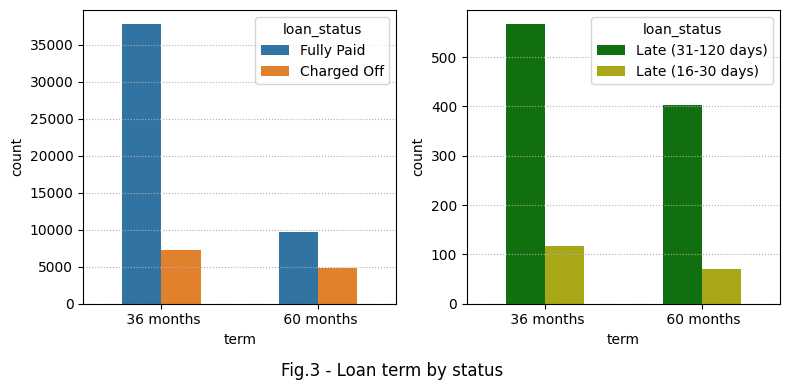

In [221]:
fig_id=3

fig, ax = plt.subplots(1,2, figsize=(8, 4))
fig = sns.countplot(data=temp1, x='term', hue='loan_status', width=0.5, ax=ax[0]) #, palette=['b','r']
ax[0].yaxis.grid(linestyle=':')
#ax[0].set_title('Status: Fully paid or Charged Off', y=-0.3)

fig = sns.countplot(data=temp2, x='term', hue='loan_status', width=0.5, ax=ax[1], palette=['g','y'])
ax[1].yaxis.grid(linestyle=':')
#ax[1].set_title('Status: Late 16-30 / 31-120 days ', y=-0.3)

plt.suptitle(f'Fig.{fig_id} - Loan term by status ', y=-0.0)
#ax.set_yscale('log');
plt.tight_layout()

plt.savefig(os.path.join(path_figures, f'fig_{fig_id}.png'))

Customers fully pay short-term loans more ofter, than long-term. 

### emp_length

In [222]:
get_descr('emp_length')

Employment length in years. Possible values are between 0 and 10 where 0 means less than one year and 10 means ten or more years. 


In [223]:
data['emp_length'] = data['emp_length'].apply(lambda x: str(x).replace('+ years', '')\
    .replace(' years', '').replace('< 1 year', '0')).replace('1 year', '1').replace('nan','-1').astype('int')
data['emp_length'].replace(-1, np.NaN, inplace=True)
temp1 = data[(data['loan_status']=='Fully Paid') | (data['loan_status']=='Charged Off')]
temp2 = data[(data['loan_status']=='Late (16-30 days)') | (data['loan_status']=='Late (31-120 days)')]

In [224]:
# new_order = np.array(np.sort(temp1['emp_length'].unique()))
# print('Number of unique categories: ', len(sub_grade))
# np.trim_zeros(new_order,trim='fb')

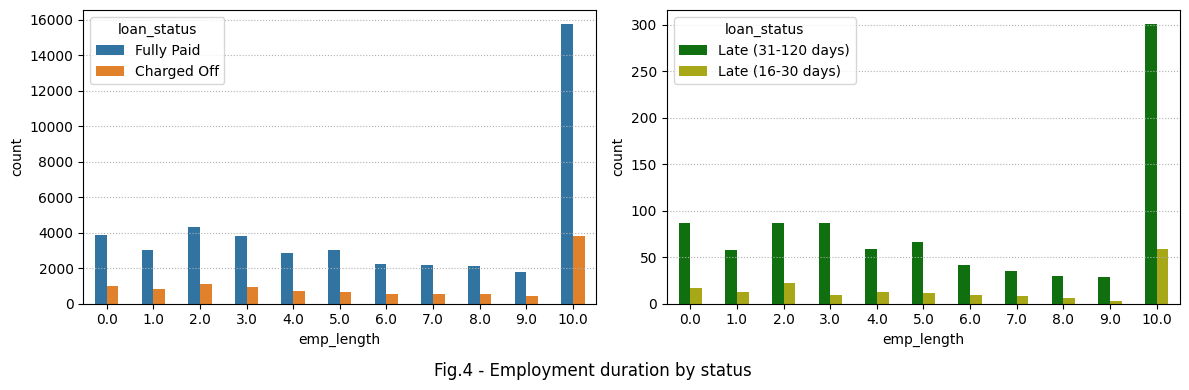

In [225]:
fig_id=4

fig, ax = plt.subplots(1,2, figsize=(12, 4))
fig = sns.countplot(data=temp1, x='emp_length', hue='loan_status', width=0.5, ax=ax[0]) #, palette=['b','r']
ax[0].yaxis.grid(linestyle=':')
#ax[0].set_title('Status: Fully paid or Charged Off', y=-0.3)

fig = sns.countplot(data=temp2, x='emp_length', hue='loan_status', width=0.5, ax=ax[1], palette=['g','y'])
ax[1].yaxis.grid(linestyle=':')
#ax[1].set_title('Status: Late 16-30 / 31-120 days ', y=-0.3)

plt.suptitle(f'Fig.{fig_id} - Employment duration by status ', y=-0.0)
#ax.set_yscale('log');
plt.tight_layout()

plt.savefig(os.path.join(path_figures, f'fig_{fig_id}.png'))

### emp_title

In [226]:
data['emp_title'].nunique()

28721

In [227]:
data['emp_title'] = data['emp_title'].apply(str).str.strip()

In [228]:
#data['emp_title'] = data['emp_title'].astype('string')
#data['emp_title'] = data['emp_title'].str.replace(',', '')
#data['emp_title'] = pd.to_numeric(data['emp_title'], errors='coerce')

In [229]:
#  lower case
data['emp_title'] = data['emp_title'].apply(lambda x: x.lower().replace('/',' '))

In [230]:
def get_professions(arg:str)->str:
    """Categorization of popular professions

    Args:
        arg (str): строка датафрейма

    Returns:
        _type_: _description_
    """    
    
    arg = arg.lower()
    
    management = ['foreman','shop foreman', 'team leader','chef','superintendent','maintenance supervisor','team lead','administration', 'deputy', 'forman', 'superviser','administrative', 'admin','group leader','manger', 'crew leader', 'mgr','payroll']
    executives = ['general manager', 'vice president','director','account executive', 'sales executive','ceo', 'partner', 'president','senior vice president', 'vp','svp','cfo','cto', 'gm', 'coo','co-owner', 'vp of operations', 'vp operations', 'senior associate']
    #engineers = ['engineer','software engineer']

    employees = ['nurse', 'registered nurse', 'rn', 'lpn', 'cna', 'nursing','social worker', 'bartender', 'cook', 'machinist', 'bookkeeper','secretary','machine operator','electrician', 'operator', 'carpenter', 'pharmacist','clerk','cashier','laborer','receptionist','instructor','welder','dispatcher','bus operator', 'custodian', 'underwriter', 'realtor','conductor','mechanic','firefighter','maintenance','server','production','flight attendant', 'designer','security', 'lvn','buyer', 'agent','service tech','plumber','warehouse', 'stylist','hairstylist', 'teller', 'pastor','senior pastor','clerical','courier', 'logistics', 'shipping','transportation','porter', 'material handler','labor','painter','lineman','assembly', 'contractor','data entry','housekeeping','office','librarian','sous chef', 'nanny', 'installer','warehouse worker','assembler','table games dealer', 'adjuster', 'firefighter paramedic','millwright','baker','merchandiser','doorman','barista']
    
    skilled_laborers = ['engineer', 'officer','administrative assistant', 'administrator','paralegal', 'attorney', 'counselor','cse','supervisor', 'csr','pilot','ramp agent', 'captain','investigator','service advisor', 'human resources','at&t','recruiter', 'hr','housekeeper', \
        # law
        'lawyer', 'legal secretary', 'auditor', 
        #IT
        'it', 'programmer','software developer','it specialist','web developer','coder',
        #finance
        'banker', 'bank of america','accounts payable','medical biller','controller','accountant', 'accounting', 'personal banker','broker','business development','loan processor','financial advisor','payroll specialist','jp morgan chase','stocker','relationship banker','estimator','mortgage banker','finance','biller','accounts receivable','cpa','cma','billing','account representative', 'wells fargo',
        # education
        'professor','teacher', 'educator', 'faculty','dean','paraprofessional','lecturer',
        #security
        'security guard','lieutenant','united states air force','sergeant', 'inspector','staff sergeant', 'deputy sheriff','border patrol agent', 'detective','special agent','us army','major', 'department of defense','lockheed martin','us air force','us navy','detective','u.s. army',
        # sales
        'sales rep','sales', 'sales representative','dealer','purchasing','collector', 'purchasing agent', \
        # medics
        'physician', 'dental hygienist','pharmacy tech', 'paramedic', 'caregiver','dentist','phlebotomist', 'optician','psychologist','speech language pathologist','resident physician', 'veterinarian','respiratory therapist', 'care giver','kaiser permanente',\
        # other
        'advisor','trainer','claims adjuster', 'principal', 'associate','graphic designer','marketing', 'quality control','lead','chemist','specialist','scientist','operations',
        ]
    #sales = []
    

    if arg in executives or 'owner' in arg or 'president' in arg: 
        return 'executive' 
    
    elif arg in management or 'manager' in arg or 'supervisor' in arg or 'executive' in arg or 'coordinator' in arg or 'lead' in arg or 'foreman' in arg or 'forman' in arg or 'head' in arg or 'supervisior' in arg or 'director' in arg or 'mgr' in arg or 'management' in arg or 'managing' in arg:   
        return 'manager'
    
    elif arg in skilled_laborers or 'consultant' in arg or 'analyst' in arg or 'officer' in arg or 'engineer' in arg or 'accountant' in arg or 'administrator' in arg or 'counselor' in arg or 'insurance' in arg or 'police' in arg or 'it' in arg or 'professor' in arg or 'teacher' in arg or 'specialist' in arg or 'programmer' in arg or 'scientist' in arg or 'developer' in arg or 'coder' in arg or 'psychologist' in arg or 'therapist' in arg or 'agent' in arg or 'officer' in arg or 'attorney' in arg or 'paralegal' in arg or 'minister' in arg or 'research' in arg or 'buyer' in arg or 'billing' in arg or 'associate' in arg or 'planner' in arg or 'representative' in arg or 'professional' in arg:
        return 'skilled_laborer'
    
    elif arg in employees or 'technician' in arg or 'operator' in arg or 'assistant' in arg or 'nurse' in arg or 'tech' in arg or 'sales' in arg  or 'service' in arg or 'controller' in arg or 'mail' in arg or 'ups' in arg or 'usps' in arg or 'post' in arg or 'staff' in arg or 'worker' in arg or 'clerk' in arg or 'mechanic' in arg or 'carrier' in arg or 'machinist' in arg or 'desk' in arg or 'manufacturing' in arg or 'driver' in arg:
        return 'employee'
   
    else:
        return 'other'

In [231]:
data['emp_title'] = data['emp_title'].apply(get_professions)
data['emp_title'].value_counts().nlargest(80).index

Index(['skilled_laborer', 'other', 'manager', 'employee', 'executive'], dtype='object')

In [232]:
data['emp_title'].value_counts(True).nlargest(8)

skilled_laborer    0.272317
other              0.260528
manager            0.233949
employee           0.186793
executive          0.046414
Name: emp_title, dtype: float64

# Preprocessing

In [233]:
# Delete less informative feature 'grade'
data.drop(['sub_grade'], axis=1, inplace=True)

data_copy = data.query("loan_status in ['Fully Paid', 'Charged Off']")

In [234]:
X, y = data_copy.drop('loan_status', axis=1), data_copy['loan_status']

In [235]:
num_features = [s for s in X.columns if X[s].dtypes != 'object']
сat_features = [s for s in X.columns if X[s].dtypes == 'object']
num_features

['loan_amnt', 'int_rate', 'installment', 'emp_length']

In [236]:
scaler = StandardScaler() #RobustScaler()  #MinMaxScaler() #
X[num_features] = scaler.fit_transform(X[num_features].values)
X

,loan_amnt,term,int_rate,installment,grade,emp_title,emp_length
1,-0.549266,36 months,-0.065033,-0.435158,C,other,NaN
2,-1.190278,36 months,-1.381770,-1.198917,A,skilled_laborer,-0.530196
3,-0.958484,36 months,-0.499076,-0.916750,B,employee,1.094081
5,0.641186,36 months,-0.795394,0.773013,B,manager,1.094081
...,...,...,...,...,...,...,...
99994,-1.510784,36 months,-0.739052,-1.520207,B,manager,1.094081
99996,1.236411,36 months,0.769666,1.754940,D,executive,1.094081
99997,-0.503479,36 months,0.419092,-0.340835,C,other,-0.800908
99999,-0.274546,36 months,-1.442286,-0.268418,A,skilled_laborer,-0.530196


In [237]:
# Feature encoding
X = pd.get_dummies(X)
X.head()

,loan_amnt,int_rate,installment,emp_length,...,emp_title_executive,emp_title_manager,emp_title_other,emp_title_skilled_laborer
1,-0.549266,-0.065033,-0.435158,NaN,...,0,0,1,0
2,-1.190278,-1.381770,-1.198917,-0.530196,...,0,0,0,1
3,-0.958484,-0.499076,-0.916750,1.094081,...,0,0,0,0
5,0.641186,-0.795394,0.773013,1.094081,...,0,1,0,0
6,-1.533678,-1.068758,-1.547521,NaN,...,0,0,1,0


In [238]:
X['emp_length'].isna().value_counts()

False    56024
True      3470
Name: emp_length, dtype: int64

## Missing values

In [248]:
cols_null_percent = data.isna().mean()*100
cols_null = cols_null_percent[cols_null_percent > 0].sort_values(ascending=False)
display(cols_null)

emp_length    5.897774
dtype: float64

In [239]:
imputer =  KNNImputer(n_neighbors=5, weights="uniform", metric='nan_euclidean')
X = pd.DataFrame(imputer.fit_transform(X), columns=X.columns)
X['emp_length'].isna().value_counts()

False    59494
Name: emp_length, dtype: int64

### Target feature

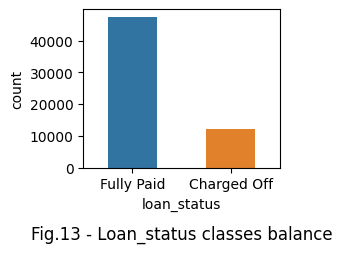

In [241]:
fig_id = 13

fig, ax = plt.subplots(figsize=(3, 3)) 
sns.countplot(data=data_copy, x='loan_status', width=0.5)
ax.set_title(f'Fig.{fig_id} - Loan_status classes balance', y=-0.5)
plt.tight_layout();

#plt.savefig(os.path.join(path_figures + f'fig_{fig_id}.png'))

#print(targets['Sales_CLoans'].value_counts(True).round(2))

In [242]:
y = y.apply(lambda x: 1 if x=='Fully Paid' else 0)

unique, counts = np.unique(y, return_counts=True)
print(unique, counts)

[0 1] [12034 47460]


### balancing classes

In [243]:
# Synthetic resampling of minority class
sm = SMOTE(random_state=random_seed)
X, y = sm.fit_resample(X, y)

unique, counts = np.unique(y, return_counts=True)
print('After synthetic resampling : ',unique, counts)

After synthetic resampling :  [0 1] [47460 47460]


## Encoding

In [244]:
# Split data by 3 samples: train, test and valid
X_train, X_valid, y_train, y_valid = train_test_split(X, y, test_size=0.2,  random_state=random_seed)
X_test, X_valid, y_test, y_valid  = train_test_split(X_valid, y_valid, test_size=0.5, random_state=random_seed)

# Check samples shapes
print('Train shape: {}'.format(X_train.shape))
print('Test shape:  {}'.format(X_test.shape))
print('Valid shape: {}'.format(X_valid.shape))

Train shape: (75936, 18)
Test shape:  (9492, 18)
Valid shape: (9492, 18)


In [245]:
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.metrics import classification_report, roc_curve, roc_auc_score

In [246]:
def get_ROC_plot(model,  X_test, y_test, title:str, fig_id:int=None):
    """
    Create the roc curve plot
    Args:
        model (_type_): pre-trained model to get prediction
        X_valid (_type_): X matrice with 
        y_valid (_type_): y predicted values
        title (_type_): _description_
        figpath (_int_): figure path for saving
    """
    y_pred = model.predict_proba(X_valid)[:,1]
    print('roc_auc: ', roc_auc_score(y_valid, y_pred).round(3))

    false_positive_rates, true_positive_rates, threshold = roc_curve(y_valid, y_pred)


    # Plot
    fig, ax = plt.subplots(figsize=(5, 5))

    # ROC curve
    ax.plot(false_positive_rates, true_positive_rates, 
            label='Smoothed values ROC-AUC')

    # Random model
    ax.plot([0, 1], [0, 1], color='k', lw=2, linestyle=':', 
            label='Model predicting random')

    ax.set_title(f'Fig.{fig_id} - ROC curve for {title}', y=-0.2)
    ax.set_xlabel('False Positive Rate')
    ax.set_ylabel('True Positive Rate')

    ax.fill_between(false_positive_rates, 
                    true_positive_rates, 
                    step="pre", 
                    alpha=0.4, label='Area under curve (ROC-AUC)')
    
    # Annotate figure with ROC cureve
    plt.annotate(f'ROC: {roc_auc_score(y_valid, y_pred).round(3)}', xy=(0.45,0.6), textcoords='data', 
             bbox={'facecolor': 'w', 'alpha': 0.95, 'pad': 10} 
    );
    
    ax.legend()
    plt.tight_layout();
    
    if fig_id:
        plt.savefig(os.path.join(path_figures + f'fig_{fig_id}.png'))

              precision    recall  f1-score   support

           0       0.65      0.66      0.66      4728
           1       0.66      0.65      0.66      4764

    accuracy                           0.66      9492
   macro avg       0.66      0.66      0.66      9492
weighted avg       0.66      0.66      0.66      9492

roc_auc:  0.707


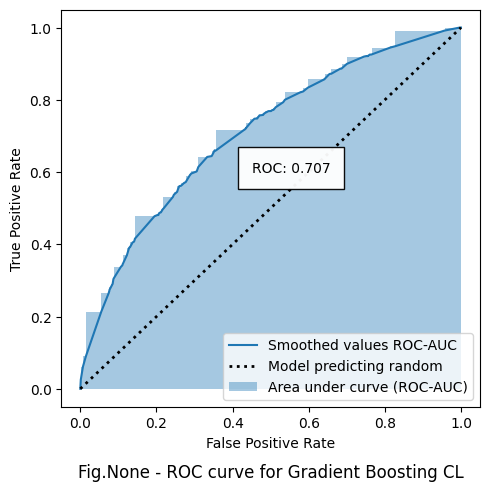

In [247]:
gb = GradientBoostingClassifier(
    learning_rate=0.01,
    n_estimators=95,
    min_samples_leaf=3,
    max_depth=3,
    random_state=random_seed
)

# train model
gb.fit(X_train, y_train)
 
# Predict target values
y_pred = gb.predict(X_test)

# Metrics report
print(classification_report(y_test, y_pred))


get_ROC_plot(gb, X_test, y_test, 'Gradient Boosting CL')

In [39]:
transformer = make_column_transformer(
    (StandardScaler(), num_features),
    (OneHotEncoder(sparse=False), сat_features), remainder = 'passthrough') #OneHotEncoder(sparse=False)
#transformer

pipeline = Pipeline([
    ('ct', transformer), 
    ('imputer', KNNImputer(n_neighbors=5, weights="uniform", metric='nan_euclidean')),
    # ('log_reg', LogisticRegression(
    #     multi_class='multinomial',  
    #     max_iter=5000,  
    #     random_state=random_seed))
    ('gb', GradientBoostingClassifier(
        learning_rate=0.01,
        n_estimators=95,
        min_samples_leaf=3,
        max_depth=3,
        random_state=random_seed))
])

In [379]:
pipeline['ct'].transformers_[1][1].get_feature_names_out().tolist()

['term_ 36 months',
 'term_ 60 months',
 'grade_A',
 'grade_B',
 'grade_C',
 'grade_D',
 'grade_E',
 'grade_F',
 'grade_G',
 'emp_title_employee',
 'emp_title_executive',
 'emp_title_manager',
 'emp_title_other',
 'emp_title_skilled_laborer']

In [234]:
transformer = transformer.fit(X)
results = transformer.transform(X)

## Other features

### settlement_percentage

In [170]:
get_descr('hardship_length')

The number of months the borrower will make smaller payments than normally obligated due to a hardship plan


In [171]:
#data['hardship_length'].value_counts()

3.0    299
Name: hardship_length, dtype: int64

### Member_id

We will not use this feature for prediction.

In [172]:
#data.drop(['member_id'], axis=1, inplace=True)

### hardship_length

In [173]:
get_descr(feature='hardship_length')

The number of months the borrower will make smaller payments than normally obligated due to a hardship plan


In [174]:
#data['hardship_length'].value_counts()

3.0    299
Name: hardship_length, dtype: int64

In [175]:
# Encoding data 
data['hardship_length'] = data['hardship_length'].apply(lambda x: 1 if x==3.0 else 0) 

### settlement_percentage

In [176]:
get_descr('settlement_percentage')

The settlement amount as a percentage of the payoff balance amount on the loan


In [177]:
data['settlement_percentage'].unique()

array([  nan, 59.98, 50.  , 60.01, 60.  , 55.  , 50.03, 45.  , 49.99,
       44.99, 50.01, 45.01, 65.  , 55.01, 44.97])

In [178]:
data['settlement_percentage'].fillna(-1, inplace=True)

In [179]:
data['settlement_percentage_group'] = pd.cut(data['settlement_percentage'], [-2,1,45,50,55,60,100], labels = ['unknown','<45','45-50','50-55','55-60','60+'])
data['settlement_percentage_group'].value_counts()

unknown    87461
<45           14
45-50         13
50-55          7
55-60          4
60+            4
Name: settlement_percentage_group, dtype: int64

In [180]:
data.drop(['settlement_percentage'],axis=1, inplace=True)

### total_bal_il

In [181]:
get_descr('total_bal_il')

Total current balance of all installment accounts


<AxesSubplot: xlabel='total_bal_il'>

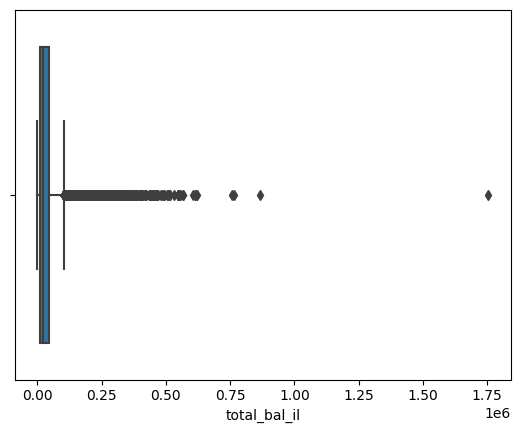

In [182]:
sns.boxplot(data=data, x='total_bal_il')

In [186]:
# imputer = KNNImputer(n_neighbors=3, weights="uniform", metric='nan_euclidean')
# data['total_bal_il'] = pd.DataFrame(imputer.fit_transform(data[['total_bal_il']]))
# data['total_bal_il'].isna().value_counts()

False    76590
True     10913
Name: total_bal_il, dtype: int64

<AxesSubplot: ylabel='total_bal_il'>

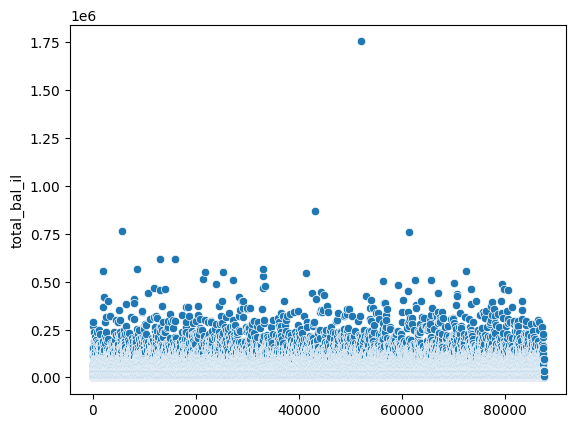

In [147]:
sns.scatterplot(data['total_bal_il'])

In [148]:
data['total_bal_il'].isna().value_counts()

False    76590
True     10913
Name: total_bal_il, dtype: int64

### emp_title

In [142]:
data['emp_title']

0                            Public Service
1                                       NaN
2                            System Analyst
3                           Admin assistant
                        ...                
99996                                   CEO
99997    Austin Independent School District
99998                               Manager
99999                   Locomotive Engineer
Name: emp_title, Length: 87503, dtype: object

In [143]:
data['emp_title'].fillna('Unknown', inplace=True)

### total_bal_il

In [145]:
get_descr('total_bal_il')

Total current balance of all installment accounts


In [ ]:
data['total_bal_il'].

In [144]:
cols_null_percent = data.isna().mean()*100
cols_null = cols_null_percent[cols_null_percent > 0].sort_values(ascending=False)
display(cols_null)

total_bal_il            36.092477
emp_length               6.263785
mort_acc                 1.942791
title                    0.866256
dti                      0.085711
revol_util               0.063998
pub_rec_bankruptcies     0.033142
dtype: float64

In [ ]:
results = []
for param_combination in param_grid:
    imputer = KNNImputer(**param_combination)
    train_pred = imputer.fit_transform(X_train)
    score = aes(y_train, train_pred)
    param_combination["train_score"]= score
    param_combination["val_score"] = aes(y_val, imputer.transform(X_val))
    results.append(param_combination)

In [126]:
imputer = KNNImputer(n_neighbors=4, weights="uniform", metric='nan_euclidean')
X = data['total_bal_il'].values.reshape(1,-1)
print(X.size)
Y = imputer.fit_transform(X)
imputer.set_output(transform='pandas')
Y

87503


array([[ 2853., 48186., 13255., ...,     0.,  8682.,  9802.]])

In [127]:
Y.size

55921

In [ ]:
n_neighbors = [1, 2, 3, 5, 7, 9, 20, 30]

fig, ax = plt.subplots(figsize=(16, 8))
# Plot the original distribution
sb.kdeplot(df.variableselected, label="Original Distribution")
for k in n_neighbors:
    knn_imp = KNNImputer(n_neighbors=k)
    density.loc[:, :] = knn_imp.fit_transform(datos)
    sb.kdeplot(density.variableselected, label=f"Imputed Dist with k={k}")

plt.legend()

In [116]:
y =  pd.DataFrame(Y, index=[data.index[0]])
y

,0,1,2,3,...,55917,55918,55919,55920
0,2853.0,48186.0,13255.0,35976.0,...,8752.0,0.0,8682.0,9802.0


In [ ]:
data['debt_settlement_flag_date'] = pd.to_datetime(data['debt_settlement_flag_date'], dayfirst=False).dt.date
data['debt_settlement_flag_date'].value_counts()

KeyError: 'debt_settlement_flag_date'

In [19]:
data['debt_settlement_flag_date'].isna().count()

87503

## Next section

Let us encode the feature manually: 

<AxesSubplot: >

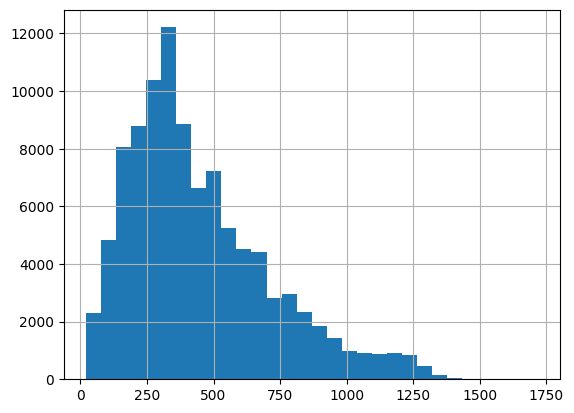

In [65]:
data['installment'].hist(bins=30)

In [72]:
data['term'].value_counts(True)

 36 months    0.710658
 60 months    0.289342
Name: term, dtype: float64

In [55]:
data.describe()

,member_id,loan_amnt,funded_amnt,funded_amnt_inv,...,hardship_last_payment_amount,settlement_amount,settlement_percentage,settlement_term
count,0.0,99996.00000,99996.000000,99996.000000,...,490.000000,1585.000000,1585.000000,1585.000000
mean,NaN,15081.25750,15076.493310,15060.101482,...,196.677469,5036.891691,47.700315,13.021451
std,NaN,9214.65121,9213.200242,9216.652945,...,195.609417,3690.770500,6.785504,8.124088
min,NaN,1000.00000,1000.000000,0.000000,...,0.020000,203.000000,15.000000,0.000000
25%,NaN,8000.00000,8000.000000,8000.000000,...,50.220000,2206.000000,45.000000,6.000000
50%,NaN,13000.00000,13000.000000,12900.000000,...,135.330000,4106.000000,45.000000,13.000000
75%,NaN,20000.00000,20000.000000,20000.000000,...,287.055000,6911.000000,50.000000,18.000000
max,NaN,40000.00000,40000.000000,40000.000000,...,1187.560000,23766.000000,90.000000,36.000000


In [54]:
data.columns.to_list()

['member_id',
 'loan_amnt',
 'funded_amnt',
 'funded_amnt_inv',
 'term',
 'int_rate',
 'installment',
 'grade',
 'sub_grade',
 'emp_title',
 'emp_length',
 'home_ownership',
 'annual_inc',
 'verification_status',
 'issue_d',
 'loan_status',
 'pymnt_plan',
 'url',
 'desc',
 'purpose',
 'title',
 'zip_code',
 'addr_state',
 'dti',
 'delinq_2yrs',
 'earliest_cr_line',
 'fico_range_low',
 'fico_range_high',
 'inq_last_6mths',
 'mths_since_last_delinq',
 'mths_since_last_record',
 'open_acc',
 'pub_rec',
 'revol_bal',
 'revol_util',
 'total_acc',
 'initial_list_status',
 'out_prncp',
 'out_prncp_inv',
 'total_pymnt',
 'total_pymnt_inv',
 'total_rec_prncp',
 'total_rec_int',
 'total_rec_late_fee',
 'recoveries',
 'collection_recovery_fee',
 'last_pymnt_d',
 'last_pymnt_amnt',
 'next_pymnt_d',
 'last_credit_pull_d',
 'last_fico_range_high',
 'last_fico_range_low',
 'collections_12_mths_ex_med',
 'mths_since_last_major_derog',
 'policy_code',
 'application_type',
 'annual_inc_joint',
 'dti_joi

In [ ]:
sns.histplot(data, y='loan_status')

<AxesSubplot: xlabel='loan_amnt'>

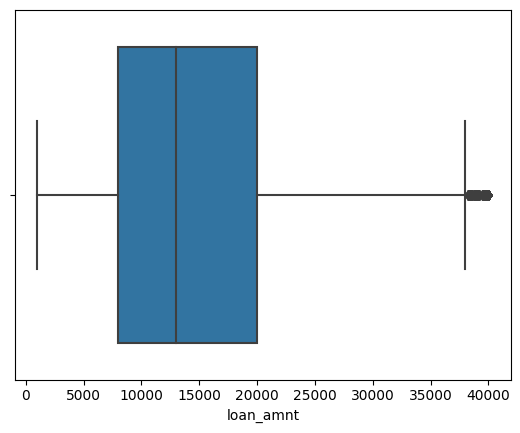

In [27]:
sns.boxplot(df, x='loan_amnt')

,id,member_id,loan_amnt,funded_amnt,...,settlement_date,settlement_amount,settlement_percentage,settlement_term
392949,39651438,NaN,32000.0,32000.0,...,NaN,NaN,NaN,NaN
1273506,16411620,NaN,9600.0,9600.0,...,NaN,NaN,NaN,NaN
324024,45122316,NaN,4000.0,4000.0,...,NaN,NaN,NaN,NaN
2066630,125356772,NaN,6025.0,6025.0,...,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...
363389,41368988,NaN,25200.0,25200.0,...,NaN,NaN,NaN,NaN
1908460,1513211,NaN,10000.0,10000.0,...,NaN,NaN,NaN,NaN
1487889,135125990,NaN,20000.0,20000.0,...,NaN,NaN,NaN,NaN
347653,43165428,NaN,12000.0,12000.0,...,NaN,NaN,NaN,NaN


In [ ]:
columns_list = df.columns.to_list()
columns_list

['id',
 'member_id',
 'loan_amnt',
 'funded_amnt',
 'funded_amnt_inv',
 'term',
 'int_rate',
 'installment',
 'grade',
 'sub_grade',
 'emp_title',
 'emp_length',
 'home_ownership',
 'annual_inc',
 'verification_status',
 'issue_d',
 'loan_status',
 'pymnt_plan',
 'url',
 'desc',
 'purpose',
 'title',
 'zip_code',
 'addr_state',
 'dti',
 'delinq_2yrs',
 'earliest_cr_line',
 'fico_range_low',
 'fico_range_high',
 'inq_last_6mths',
 'mths_since_last_delinq',
 'mths_since_last_record',
 'open_acc',
 'pub_rec',
 'revol_bal',
 'revol_util',
 'total_acc',
 'initial_list_status',
 'out_prncp',
 'out_prncp_inv',
 'total_pymnt',
 'total_pymnt_inv',
 'total_rec_prncp',
 'total_rec_int',
 'total_rec_late_fee',
 'recoveries',
 'collection_recovery_fee',
 'last_pymnt_d',
 'last_pymnt_amnt',
 'next_pymnt_d',
 'last_credit_pull_d',
 'last_fico_range_high',
 'last_fico_range_low',
 'collections_12_mths_ex_med',
 'mths_since_last_major_derog',
 'policy_code',
 'application_type',
 'annual_inc_joint',
 '